# Dataloader

This notebook implements the dataloader needed for training the Siamese network later.

In [64]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import random

Load all the classes and their images.

In [65]:
dataset_root_path = os.path.join('Data', 'LFW', 'lfw_funneled')
classes_paths = []

for dir in os.scandir(dataset_root_path):
    classes_paths.append([])
    
    for file in os.scandir(dir.path):
        if file.is_file():
            classes_paths[-1].append(file.path)

print(f"{len(classes_paths)} classes.")

5749 classes.


## Data loader implementation

In [67]:
class DataLoader(tf.keras.utils.Sequence):

    def __init__(self, dataset_path, batch_size, input_shape=(250, 250)):
        self.input_shape = input_shape
        self.batch_size = batch_size

        self.dataset_path = dataset_path
        self.classes_paths = []
        
        for dir in os.scandir(self.dataset_path):
            self.classes_paths.append([])
            
            for file in os.scandir(dir.path):
                if file.is_file():
                    self.classes_paths[-1].append(file.path)
        
        # calculate the total number of batches
        self.batches_num = len(self.classes_paths) // self.batch_size
    
    def load_img(self, path):
        image = keras.preprocessing.image.load_img(path)
        image_arr = keras.preprocessing.image.img_to_array(image)
        return image_arr / 255
        
    # the training algorithm (model.fit()) will call this function to get the n'th batch of the dataset
    def __getitem__(self, n):
        
        paths_batch = self.classes_paths[n*self.batch_size : (n+1)*self.batch_size]

        X1 = np.zeros((self.batch_size, self.input_shape[1], self.input_shape[0], 3))
        X2 = np.zeros((self.batch_size, self.input_shape[1], self.input_shape[0], 3))
        Y = np.zeros((self.batch_size, 1))

        for i in range(self.batch_size):
            sample_class_1 = random.choice(paths_batch)
            sample_class_2 = random.choice(paths_batch)

            X1[i] = self.load_img(random.choice(sample_class_1))
            X2[i] = self.load_img(random.choice(sample_class_2))
            
            if sample_class_1 == sample_class_2:
                Y[i] = 1
            else:
                Y[i] = 0
        
        #Since the model has two inputs, X1 and X2 has to be grouped into a tuple.
        return (X1, X2), Y

    # returns the number of batches in the dataset
    def __len__(self):
        return self.batches_num
    
    # called at the end of the epoch
    def on_epoch_end(self):
        # shuffle the paths of images at the end of each epoch
        np.random.shuffle(self.classes_paths)

Test the **Data Loader**

In [68]:
train_loader = DataLoader(dataset_path=dataset_root_path, batch_size=32, input_shape=(250, 250))

input batch shape is (2, 250, 250, 3)
output batch shape is (32, 1)
label is : 0.0


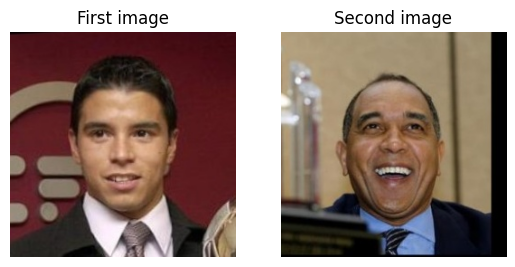

In [77]:
# get sample batch
(X1, X2), Y = train_loader[random.randint(0, len(train_loader)-1)]

# get sample pair
x1 = X1[random.randint(0, len(X1)-1)]
x2 = X2[random.randint(0, len(X2)-1)]
y_label = Y[random.randint(0, len(Y)-1)]

print(f"input batch shape is {np.concatenate([[x1], [x2]], axis = 0).shape}")
print(f"output batch shape is {Y.shape}")
print(f"label is : {y_label[0]}")

# show a sample image pair
plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.axis('off')
plt.title("First image")

plt.subplot(1, 2, 2)
plt.imshow(x2)
plt.axis('off')
plt.title("Second image")

plt.show()

## Real Example

In [78]:
Input1 = keras.layers.Input(shape = (250, 250, 3))
Input2 = keras.layers.Input(shape = (250, 250, 3))
flatten1 = keras.layers.Flatten()(Input1)
flatten2 = keras.layers.Flatten()(Input2)
feature_vector = keras.layers.Concatenate()([flatten1, flatten2])
clf_head = keras.layers.Dense(32, 'relu')(feature_vector)
output = keras.layers.Dense(1, 'sigmoid')(clf_head)

model = keras.Model(inputs = [Input1, Input2], outputs = output)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


Note that the high accuracy is not due to the fact that the model is good. <br> 
It is rather because the model mostly outputs a 0 most of the time since the majority of examples are negative. 

To do:
* Fix the dataset imbalance

In [80]:
train_loader = DataLoader(dataset_path=dataset_root_path, batch_size=32, input_shape=(250, 250))

model.fit(train_loader, epochs = 3)

Epoch 1/3
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9691 - loss: 0.1513
Epoch 2/3
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - accuracy: 0.9666 - loss: 0.1599
Epoch 3/3
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.9714 - loss: 0.1401


Test the model on an example:

In [58]:
(X1, X2), y = train_loader[0]
x1, x2, y = X1[0], X2[0], y[0]

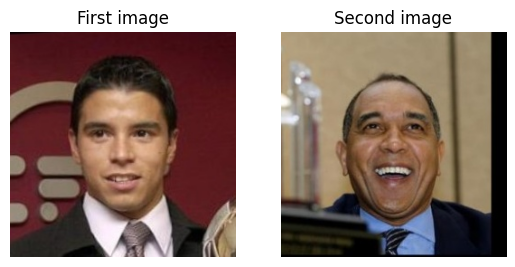

In [81]:
plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.axis('off')
plt.title("First image")

plt.subplot(1, 2, 2)
plt.imshow(x2)
plt.axis('off')
plt.title("Second image")

plt.show()

In [82]:
model.predict(x = [np.expand_dims(x1, axis = 0), np.expand_dims(x2, axis = 0)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


array([[0.05840158]], dtype=float32)